##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [2]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [3]:

df = pd.read_csv("../../data/titan/titan.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-17,1194.800049,1196.849976,1184.000000,1188.750000,1034774
1,2020-01-20,1190.000000,1195.000000,1179.099976,1187.849976,1139858
2,2020-01-21,1183.449951,1183.900024,1161.000000,1176.199951,925998
3,2020-01-22,1181.800049,1185.949951,1172.000000,1177.650024,902471
4,2020-01-23,1176.000000,1206.650024,1175.000000,1204.099976,2101116


In [4]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-05,1253.500000,1265.150024,1242.199951,1242.599976,1555538,1264.829261,1254.900000,1272.204993,1280.643327,1252.849996,40.111726,1.339990,5.788707
1,2020-03-06,1229.000000,1246.949951,1219.699951,1203.449951,1678642,1264.245090,1251.150000,1265.159997,1279.986662,1255.566663,37.826210,-0.353649,4.412463
2,2020-03-09,1225.000000,1241.849976,1175.000000,1187.650024,2285787,1262.025006,1248.769995,1257.134998,1276.286662,1256.849996,25.022177,-4.618469,2.436546
3,2020-03-11,1197.949951,1213.349976,1177.550049,1076.750000,2314388,1256.032499,1240.629980,1249.489990,1270.286662,1256.036662,23.883133,-9.095396,-0.040031
4,2020-03-12,1150.000000,1153.949951,1064.650024,1084.349976,3608906,1249.052733,1228.759985,1242.244995,1261.726660,1255.164994,11.508613,-20.904596,-4.455698


In [5]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,1242.599976,1264.829261,1254.900000,1272.204993,1280.643327,1252.849996,40.111726,1.339990,5.788707
1,1203.449951,1264.245090,1251.150000,1265.159997,1279.986662,1255.566663,37.826210,-0.353649,4.412463
2,1187.650024,1262.025006,1248.769995,1257.134998,1276.286662,1256.849996,25.022177,-4.618469,2.436546
3,1076.750000,1256.032499,1240.629980,1249.489990,1270.286662,1256.036662,23.883133,-9.095396,-0.040031
4,1084.349976,1249.052733,1228.759985,1242.244995,1261.726660,1255.164994,11.508613,-20.904596,-4.455698


#### Separating the data into train and test splits. Then splitting into validation split

In [6]:
X = df.iloc[:, 1:]
y = df.iloc[:, 1]

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [8]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [9]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [10]:
EPOCHS = 800
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [12]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [13]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

  9%|▊         | 69/800 [00:05<00:19, 36.63it/s] 

Epoch 050: | Train Loss: 26088.92795 | Val Loss: 29918.17448


 16%|█▌        | 125/800 [00:05<00:07, 86.85it/s]

Epoch 100: | Train Loss: 21251.10786 | Val Loss: 23097.94466


 21%|██        | 168/800 [00:05<00:05, 116.42it/s]

Epoch 150: | Train Loss: 16247.78060 | Val Loss: 17323.94792


 28%|██▊       | 225/800 [00:06<00:04, 132.68it/s]

Epoch 200: | Train Loss: 11962.37863 | Val Loss: 12691.03320


 33%|███▎      | 267/800 [00:06<00:03, 136.17it/s]

Epoch 250: | Train Loss: 8443.48014 | Val Loss: 8728.31559


 40%|████      | 323/800 [00:06<00:03, 136.03it/s]

Epoch 300: | Train Loss: 5172.34106 | Val Loss: 5332.86418


 46%|████▌     | 366/800 [00:07<00:03, 136.56it/s]

Epoch 350: | Train Loss: 2680.09969 | Val Loss: 2703.31274


 53%|█████▎    | 423/800 [00:07<00:02, 131.18it/s]

Epoch 400: | Train Loss: 1025.27123 | Val Loss: 1040.59412


 58%|█████▊    | 465/800 [00:08<00:02, 129.00it/s]

Epoch 450: | Train Loss: 282.02026 | Val Loss: 278.62907


 65%|██████▌   | 521/800 [00:08<00:02, 133.95it/s]

Epoch 500: | Train Loss: 56.14229 | Val Loss: 52.13825


 70%|███████   | 563/800 [00:08<00:01, 130.85it/s]

Epoch 550: | Train Loss: 13.20750 | Val Loss: 10.58470


 77%|███████▋  | 619/800 [00:09<00:01, 130.74it/s]

Epoch 600: | Train Loss: 7.22212 | Val Loss: 5.55759


 84%|████████▍ | 675/800 [00:09<00:00, 129.35it/s]

Epoch 650: | Train Loss: 5.61722 | Val Loss: 5.09535


 90%|████████▉ | 717/800 [00:09<00:00, 134.02it/s]

Epoch 700: | Train Loss: 5.37053 | Val Loss: 5.12772


 97%|█████████▋| 773/800 [00:10<00:00, 129.51it/s]

Epoch 750: | Train Loss: 5.29898 | Val Loss: 5.30448


100%|██████████| 800/800 [00:10<00:00, 75.26it/s] 

Epoch 800: | Train Loss: 5.29268 | Val Loss: 5.32670


In [16]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

800
800


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

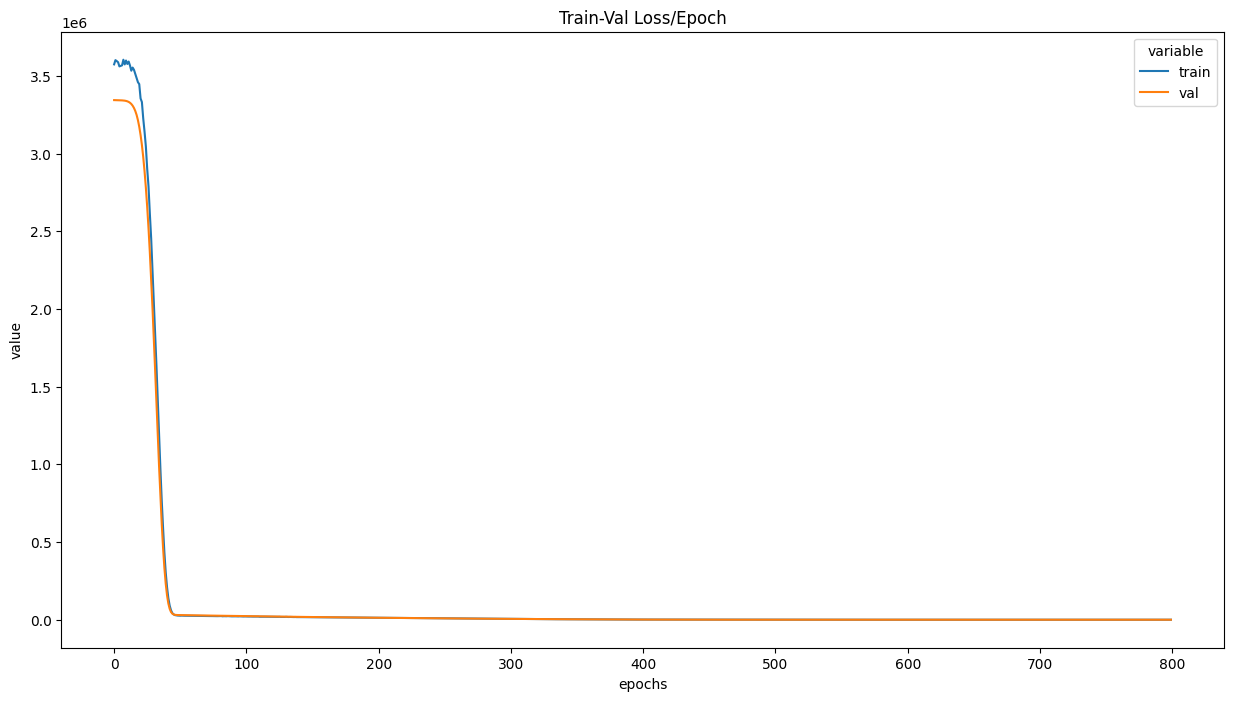

In [17]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

100%|██████████| 3/3 [00:00<00:00, 19878.22it/s]

[2630.2695, 2626.1729, 2622.1343, 2623.524, 2620.662, 2615.9067, 2613.176, 2604.5693, 2591.6282, 2584.7104, 2575.9663, 2565.0613, 2557.1504, 2550.3933, 2542.559, 2536.9617, 2540.6985, 2542.4207, 2549.303, 2552.4321, 2558.725, 2561.3618, 2563.3145, 2561.907, 2555.9214, 2547.0488, 2534.6091, 2525.4612, 2514.1414, 2505.2698, 2494.7424, 2487.505, 2476.4778, 2466.2039, 2456.3064, 2446.8203, 2436.2917, 2425.4192, 2416.126, 2412.7327, 2406.944, 2396.2085, 2403.5867, 2410.63, 2415.1677, 2421.4897, 2428.0881, 2431.3506, 2439.5588, 2445.848, 2452.9346, 2461.4514, 2465.6277, 2465.0447, 2464.1475, 2462.822, 2456.5889, 2449.4614, 2443.845, 2435.6829, 2429.5835, 2422.8674, 2419.5613, 2417.451, 2415.576, 2410.571, 2408.1802, 2400.5745, 2395.0854, 2394.2854, 2400.6218, 2408.0757, 2414.379, 2425.5173, 2434.2373, 2443.4263, 2449.4084, 2455.327, 2458.5813, 2463.469, 2466.0085, 2472.5688, 2483.5989, 2490.2808, 2499.0935, 2506.53, 2515.1775, 2521.2036, 2530.0068, 2533.6035, 2536.779, 2541.2075, 2543.2024, 

[Text(0.5, 1.0, 'Deviation of Error')]

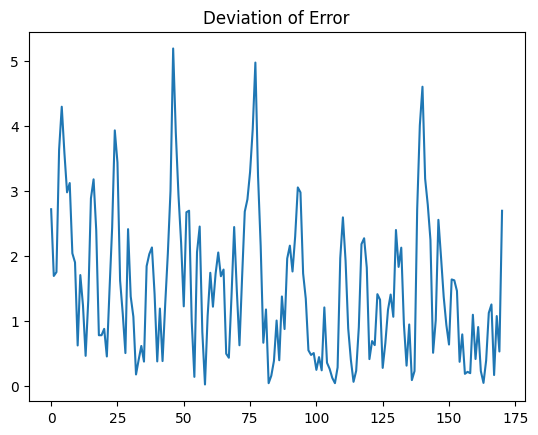

In [18]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())
y_pred_np = np.array(y_pred)
difference = np.subtract(y_pred_np, y_test)
difference = abs(difference)
mean_difference = np.mean(difference)
print(f"The average deviation in error is: {mean_difference}")
sns.lineplot(difference).set(title="Deviation of Error")

In [19]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")

Mean Squared Error : 3.529383413854193
R^2 : 0.9999190726053202
Accuracy (using MSE): 96.47061658614581%


#### Visualising the data

In [20]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [21]:
test_vals = temp.index[x_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()